In [1]:
import os
import glob
import gudhi
import glob
import pandas as pd
import persim 
from persim import PersImage
from persim import PersistenceImager
from persim.landscapes import snap_pl, plot_landscape_simple, PersLandscapeApprox, PersLandscapeExact, average_approx, plot_landscape
from scipy.spatial import distance_matrix
import numpy as np
from itertools import combinations
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import re
from natsort import natsorted
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import norm

In [2]:
plt.rcParams.update(plt.rcParamsDefault)

In [3]:
params = df_params_file = (pd.read_csv('data/params_file.csv'))

In [4]:
ts = [250,300,350,400,450,500]
d_file = []
for ID in df_params_file.id:
    for t in ts:
        d_file.append(glob.glob(f'data/ID-{ID}_time-{t}_From*ParamSweep_Data.csv')[0])
d_files = natsorted(d_file)


In [5]:
# Store IDs and Times:
IDs = []
import re
for fname in d_files:
    res = re.findall("ID-(\d+)_time", fname)
    if not res: continue
    IDs.append(int(res[0])) 
    
Times = []
for fname in d_files:
    res = re.findall("_time-(\d+)_", fname)
    if not res: continue
    Times.append(int(res[0]))


In [6]:
ids = df_params_file[['id']].to_numpy()

m_status = df_params_file[['end_has_niche']].to_numpy()

metas_ind = ids[np.where(m_status == True)]
nonmetas_ind = ids[np.where(m_status == False)]

In [7]:
N = len(d_files)
dfs = [] # datafiles of simulation data stored here
for f in d_files:
    dfs.append(pd.read_csv(f))

In [8]:
# list of df of just stroma, tumour and macrophage and lists of np arrays of coords:
dfs_stroma = []
for i in range(N):
    dfs_stroma.append(dfs[i].loc[dfs[i]['celltypes'] == 'Stroma'])
dfs_tumour = []
for i in range(N):
    dfs_tumour.append(dfs[i].loc[dfs[i]['celltypes'] == 'Tumour'])
dfs_macrophage = []
for i in range(N):
    dfs_macrophage.append(dfs[i].loc[dfs[i]['celltypes'] == 'Macrophage'])
dfs_vessel = []
for i in range(N):
    dfs_vessel.append(dfs[i].loc[dfs[i]['celltypes'] == 'Vessel'])
dfs_necrosis = []
for i in range(N):
    dfs_necrosis.append(dfs[i].loc[dfs[i]['celltypes'] == 'Necrotic'])


array = dfs[0][["points_x", "points_y"]].to_numpy()
# numpy array with points for Stroma: 
coords_stroma = []
for i in range(N                                                                                                                                                                                                                                                                                   ):
    coords_stroma.append(dfs_stroma[i][['points_x','points_y']].to_numpy())
coords_tumour = []
for i in range(N):
    coords_tumour.append(dfs_tumour[i][['points_x','points_y']].to_numpy())
coords_macrophage =[]
for i in range(N):                  
    coords_macrophage.append(dfs_macrophage[i][['points_x','points_y']].to_numpy())
coords_vessel = []
for i in range(N):
    coords_vessel.append(dfs_vessel[i][['points_x','points_y']].to_numpy())                                  


In [9]:
def getTree(ID, dim = 0, EPS = 2):
   
 
    def getSC(k, MU): # k is index for coords_tumour; MU is radius for expansion
        ptset = coords_tumour[k]
        tree = gudhi.SimplexTree()
        N = len(ptset)

        P = np.array([25.25])
        dist2 = [np.linalg.norm(p) for p in (ptset - P)]

      #  print(np.amax(dist2))

        dist2centre = 50 - np.array(dist2)

        # Distances between points
        dist_self = distance_matrix(ptset, ptset)
        dist_pairs_with_identicals = np.argwhere( dist_self < MU ) 
        mask = (dist_pairs_with_identicals[:, 0] != dist_pairs_with_identicals[:,1])
        dist_pairs = dist_pairs_with_identicals[mask, :] 

        for i in range(N):
            tree.insert([i],dist2centre[i])

        for i,j in dist_pairs: 
            tree.insert([i,j], max(dist2centre[i],dist2centre[j]))

        tree.expansion(2) # adds all the 2 simplicies, with filtration value being max edge filtration value. 
        return tree

    trees = []
    bars_0 = []
    bars_1 = []

    ind = np.where(np.array(IDs) == ID)
    id_number = ind[0]

    for n in id_number:
        tree = getSC(n,EPS)
        trees.append(tree)
        tree.compute_persistence()
        bars_0.append(tree.persistence_intervals_in_dimension(0).reshape((-1,2)))
        bars_1.append(tree.persistence_intervals_in_dimension(1))
        
    return [trees, [Times[i] for i in id_number], bars_0, bars_1]

In [10]:
# For a list of persistence bars, set the inf values to Big

def replaceInf(ls_of_bars,Big):
    new_ls = []
    for i in range(len(ls_of_bars)):
        ls_of_bars[i][ls_of_bars[i] == np.inf] = Big
        new_ls.append(ls_of_bars[i])
    return new_ls

def removeInf(ls_of_bars):
    new_ls = []
    for i in range(len(ls_of_bars)):
        altered = new_ls.append(ls_of_bars[i][ls_of_bars[i][:,1] != np.inf])
    return new_ls

def get_infBirths(ls_of_bars):
    new_ls = []
    for i in range(len(ls_of_bars)):
        new_ls.append(ls_of_bars[i][ls_of_bars[i][:,1] == np.inf][:,0])
    return new_ls

In [11]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

In [12]:
def getG(bs, scale):
    ys = [0]*101
    for b in bs:
        for i in range(len(ys)):
            x = i/100*50
            ys[i] += gaussian(x, b, scale)
    return ys

In [ ]:
# Visualisation of gaussians across timepoints for a single ID 
ID = 561 
trees, times, bars_0, bars_1 = getTree(ID)
for i in range(len(bars_0)):
    fig, ax = plt.subplots(1, 1)
    pltpts = getG(get_infBirths(bars_0)[i], scale = 1.1)
    ax.plot(np.linspace(0,50,101), pltpts,
           'r-', lw=5, alpha=0.6, label='norm pdf')
    plt.show()
    plt.clf()
    plt.close()

In [ ]:
# Data analysis pipeline for a single pointcloud
index = 1
xs =  coords_tumour[index][:,0].tolist() + coords_macrophage[index][:,0].tolist() + coords_vessel[index][:,0].tolist()
ys =  coords_tumour[index][:,1].tolist() + coords_macrophage[index][:,1].tolist() + coords_vessel[index][:,1].tolist()
cells = ['tumour' for i in coords_tumour[index]] + ['macrophage' for i in coords_macrophage[index]] + ['vessel' for i in coords_vessel[index]]
df = { 'x': xs, 'y': ys, 'type': cells }

In [ ]:
trees, times, bars_0, bars_1 = getTree(1,EPS = 0.7 )

In [ ]:
fig = plt.gcf()
ax = plt.gca()
plt.gca().set_aspect('equal', adjustable='box')
ax.xaxis.set_visible(False)
plt.scatter(xs,ys, marker ='x', c='black' )

fig.set_size_inches(10,10)
fig.set_dpi(200)
plt.show()
# plt.savefig('tumours.png')

In [ ]:
persim.plot_diagrams(bars_0[0])

fig = plt.gcf()

fig.set_size_inches(8,8)
fig.set_dpi(200)
plt.show()
# plt.savefig('example_persistence.png')


In [ ]:
# Get persistence images
pimgr = PersistenceImager(pixel_size=0.2)
pimgr.fit([removeInf(bars_0)[0]])
imgs = pimgr.transform([removeInf(bars_0)[0]])

imgs_array = np.array([img.flatten() for img in imgs])

mn = np.mean([img for img in imgs], axis = 0)
ax = plt.subplot(111)
fig = plt.gcf()

fig.set_size_inches(8,8)
fig.set_dpi(200)
pimgr.plot_image(mn,ax)
plt.show()
# plt.savefig('example_persimg.png')

In [ ]:
trees, times, bars_0, bars_1 = getTree(1, EPS = 0.7)
fig, ax = plt.subplots(1, 1)
pltpts = getG(get_infBirths(bars_0)[0], scale = 1)
ax.plot(np.linspace(0,50,101), pltpts,
       '-', lw=2, alpha=1, label='norm pdf', c = 'black')
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
fig.set_size_inches(8,4)
fig.set_dpi(200)
plt.show()
# plt.savefig('gaussian.png')

### Combining vectorized inf bars and remaining persistence images 

In [13]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [14]:
# Get elim and diff versions with inf as large
def zippedM(tpt_ind, std = 1, EPS = 0.7):
    diagrams_h0 = []
    labels_ls = []
    empty_count = []
    actual_inds = []
    for ind in metas_ind:
        counter = 0 
        trees, times, bars_0, bars_1 = getTree(ind, EPS = EPS)
        if len(bars_0) > tpt_ind:
            removed = removeInf(bars_0)[tpt_ind]
            if len(bars_0[tpt_ind]) != 0:
                if removed.size != 0:
                    diagrams_h0.append(removed)
                else:
                    diagrams_h0.append(np.zeros((1,2)))
                labels_ls.append(0)
            actual_inds.append(ind)
        else:
            counter += 1
        empty_count.append(counter)

    for ind in nonmetas_ind:
        trees, times, bars_0, bars_1 = getTree(ind, EPS = EPS)
        if len(bars_0) > tpt_ind:
            removed = removeInf(bars_0)[tpt_ind]
            if len(bars_0[tpt_ind]) != 0:
                if removed.size != 0:
                    diagrams_h0.append(removed)
                else:
                    diagrams_h0.append(np.zeros((1,2)))
                labels_ls.append(1)
            actual_inds.append(ind)
        else:
            counter+=1
        empty_count.append(counter)
    labels = np.array(labels_ls)
    pimgr = PersistenceImager(pixel_size=0.2)
    pimgr.fit(diagrams_h0)
    imgs = pimgr.transform(diagrams_h0)
    imgs_array = np.array([img.flatten() for img in imgs])
    
    # get a 2D np array, rows = gaussians. 
    # 
    # based on timepoint_ind:
    ls_gauss = []
    lab_gauss = []
    other_inds = []
    for ind in metas_ind:
        trees, times, bars_0, bars_1 = getTree(ind)
        if len(bars_0) > tpt_ind:
            infs = get_infBirths(bars_0)[tpt_ind]
            if len(bars_0[tpt_ind]) != 0:
                if infs.shape[0]!=0:
                    ls_gauss.append(getG(infs, scale = std))
                elif len(bars_0[tpt_ind]) != 0:
                    ls_gauss.append(np.linspace(0,50,100))
                lab_gauss.append(0)
                other_inds.append(ind)
    #         print(bars_0[n].shape[0])
    for ind in nonmetas_ind:
        trees, times, bars_0, bars_1 = getTree(ind)
        if len(bars_0) > tpt_ind:
            infs = get_infBirths(bars_0)[tpt_ind]
            if len(bars_0[tpt_ind]) != 0:
                if infs.shape[0]!=0:
                    ls_gauss.append(getG(infs, scale = std))
                elif len(bars_0[tpt_ind]) != 0:
                    ls_gauss.append(np.linspace(0,50,100))
                lab_gauss.append(1)
                other_inds.append(ind)

    gauss_array = np.array(ls_gauss)
#     return [gauss_array, imgs_array, actual_inds, other_inds]
    #zipping the two vectors:
    combined_array = np.hstack((gauss_array,imgs_array))
    emp_array = np.zeros((empty_count[0]+empty_count[1],len(combined_array[0])  ))
    with_zeroes_array = np.concatenate((combined_array, emp_array))
    
    labels = labels_ls + [0 for i in range(empty_count[0])] + [1 for i in range(empty_count[1])]
    return [with_zeroes_array, labels, pimgr]

In [15]:
# Getting ML accuracy scores for all the timesteps radial vectorization: 
print(t)
EPS = 0.7
# tpt_inds = [0,1,2,3,4,5]
tpt_inds = [2]
ls_avescores = []
ls_arrays = []
# regression_coeffs = []
ls_objects = []
for tpt in tpt_inds:
    combined_array, labels, pimgr = zippedM(tpt, EPS= EPS)
    ls_objects.append([combined_array, labels])
    lr = LogisticRegression(max_iter=50_000)
    scores = []
    inverses = []
    cv = RepeatedStratifiedKFold()
    flat_scores = cross_val_score(lr, combined_array, labels, cv=cv)
    array = np.array(flat_scores)
    ls_avescores.append(np.mean(array))
    print(ls_avescores[-1])
    ls_arrays.append(array)

500
0.862366802236909


In [ ]:
import plotly.express as px

In [ ]:
# box plot of radial filtration accuracies 
ls_times = []
for t in tpt_inds:
    for j in range(50):
        ls_times.append(t)
df = pd.DataFrame({'Timestep': ls_times, 'Accuracy': np.array(ls_arrays).flatten() })
fig = px.box(df, x = 'Timestep', y="Accuracy", points = 'all', color = 'Timestep',color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(showlegend=False)
fig.show()

In [ ]:
from scipy.spatial.distance import cdist

def getDist(ind, timept):
    inds = np.where(np.array(IDs) == ind)
    tumour = coords_tumour[inds[0][timept]]
    vessels = coords_vessel[inds[0][timept]]
    return np.min(np.min(cdist(tumour,vessels)))

In [ ]:
# Tumour cell dist to vessel benchmark accuracy scores:
from sklearn.model_selection import RepeatedStratifiedKFold
tpt_inds = [0,1,2,3,4,5]
total_scores_TV = []
average_scores_TV= []
for tpt_ind in tpt_inds:
    labels_d = []
    dists = []
    for ind in metas_ind:
        inds = np.where(np.array(IDs) == ind)
        if len(inds[0]) > tpt_ind:
            tumour = coords_tumour[inds[0][tpt_ind]]
            if len(tumour) > 0:
                vessels = coords_vessel[inds[0][tpt_ind]]
                dists.append(np.array([np.min(np.min(cdist(tumour,vessels)))]))
                labels_d.append(0)
    for ind in nonmetas_ind:
        inds = np.where(np.array(IDs) == ind)
        if len(inds[0]) > tpt_ind:
            tumour = coords_tumour[inds[0][tpt_ind]]
            if len(tumour) > 0:
                vessels = coords_vessel[inds[0][tpt_ind]]
                dists.append(np.array([np.min(np.min(cdist(tumour,vessels)))]))
                labels_d.append(1)
    dists_array = np.array(dists)
    lr = LogisticRegression(max_iter=50_000)
    scores = []
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = 42)
    scores.append(cross_val_score(lr, dists_array, labels_d, cv=cv, n_jobs=-1))
    total_scores_TV.append(np.concatenate(scores).ravel())
    average_scores_TV.append(np.mean(np.concatenate(scores).ravel()))
total_scores_TV = np.array(total_scores_TV)

In [ ]:
# Tumour cell count benchmark accuracy scores:
tpt_inds = [0,1,2,3,4,5]
total_scores_MC = []
average_scores_MC = []
for tpt_ind in tpt_inds:
    labels_tumour = []
    counts = []
    for ind in metas_ind:
        inds = np.where(np.array(IDs) == ind)
        if len(inds[0]) > tpt_ind:
            counts.append(np.array([len(coords_macrophage[inds[0][tpt_ind]])]))
            labels_tumour.append(0)
    for ind in nonmetas_ind:
        inds = np.where(np.array(IDs) == ind)
        if len(inds[0]) > tpt_ind:
            counts.append(np.array([len(coords_macrophage[inds[0][tpt_ind]])]))
            labels_tumour.append(1)
    counts_array = np.array(counts)
    lr = LogisticRegression(max_iter=50_000)
    scores = []
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = 42)
    scores.append(cross_val_score(lr, counts_array, labels_tumour, cv=cv, n_jobs=-1))
    total_scores_MC.append(np.concatenate(scores).ravel())
    average_scores_MC.append(np.mean(np.concatenate(scores).ravel()))
total_scores_MC = np.array(total_scores_MC)

In [ ]:
# Tumour cell count benchmark accuracy scores:
tpt_inds = [0,1,2,3,4,5]
total_scores_TC = []
average_scores_TC = []
for tpt_ind in tpt_inds:
    labels_tumour = []
    counts = []
    for ind in metas_ind:
        inds = np.where(np.array(IDs) == ind)
        if len(inds[0]) > tpt_ind:
            counts.append(np.array([len(coords_tumour[inds[0][tpt_ind]])]))
            labels_tumour.append(0)
    for ind in nonmetas_ind:
        inds = np.where(np.array(IDs) == ind)
        if len(inds[0]) > tpt_ind:
            counts.append(np.array([len(coords_tumour[inds[0][tpt_ind]])]))
            labels_tumour.append(1)
    counts_array = np.array(counts)
    lr = LogisticRegression(max_iter=50_000)
    scores = []
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = 42)
    scores.append(cross_val_score(lr, counts_array, labels_tumour, cv=cv, n_jobs=-1))
    total_scores_TC.append(np.concatenate(scores).ravel())
    average_scores_TC.append(np.mean(np.concatenate(scores).ravel()))
total_scores_TC = np.array(total_scores_TC)

In [ ]:
ls_times = []
for i in range(6):
    for j in range(50):
        ls_times.append([250,300,350,400,450,500][i])

df = pd.DataFrame({'Timestep': ls_times, 'Accuracy': total_scores_TC.flatten() })
# fig = go.Figure(data = [go.Box(df, x = 'Timestep', y = "Accuracy")])
fig = px.box(df, x = 'Timestep', y="Accuracy", points = 'all', color = 'Timestep',color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(showlegend=False)
fig.show()

In [ ]:
# Plot of benchmarks together:
import plotly.express as px
import plotly.graph_objects as go
ls_times = []
for t in tpt_inds:
    for j in range(50):
        ls_times.append([250,300,350,400,450,500][t])

df = pd.DataFrame({'Timestep': ls_times, 'Accuracy': np.array(ls_arrays).flatten() })
# fig = go.Figure(data = [go.Box(df, x = 'Timestep', y = "Accuracy")])
fig = px.box(df, x = 'Timestep', y="Accuracy", points = 'all', color = 'Timestep',color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(showlegend=False)

fig.add_trace(go.Scatter( name = 'Tumour Count',
x = [250,300,350,400,450,500], y = average_scores_TC, mode = 'lines', line = dict(color='black', dash = 'dash')))
fig.add_trace(go.Scatter( name = 'Tumour-Vessel Distance', x = [250,300,350,400,450,500], y = average_scores_TV, mode = 'lines', line = dict(color = 'blue', dash = 'dash')))


fig.add_trace(go.Scatter( name = 'Macrophage Phenotype', x = [250,300,350,400,450,500], y = [0.69737374, 0.72781145, 0.79259259, 0.81171717, 0.82141414,0.80444444], mode = 'lines', line = dict(color = 'red', dash = 'dash')))

fig.update_layout(legend_title_text=None)
fig.show()

In [ ]:
ls_arrays

In [ ]:
average_scores_TC

In [ ]:
average_scores_MC

In [ ]:
average_scores_TV

In [ ]:
[0.69737374, 0.72781145, 0.79259259, 0.81171717, 0.82141414,0.80444444]

In [16]:
import bats
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import persim
import plotly.express as px
import plotly.graph_objects as go
import ripser
import tqdm
from itertools import combinations
from natsort import natsorted
from persim import PersistenceImager
from scipy.spatial import distance_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [17]:
def rips_dgms0(Id, celltype):
    files = natsorted(glob.glob(f'data/ID-{Id}_time-*_From*ParamSweep_Data.csv'))[START:END:STEP]

    bars = []
    for i,f in enumerate(files):
        df = pd.read_csv(f)
        mp = df[df.celltypes == celltype][['points_x', 'points_y']].to_numpy()
        if mp.size == 0: 
            continue
        else:
            dgms = ripser.ripser(mp, distance_matrix=False, maxdim=0)['dgms'][0]
            bars.extend( 
                dgms[dgms[:,1] != np.inf] 
                + [i, 0] 
            )

    return np.array(bars)


def rips_dgms1(Id, celltype):
    files = natsorted(glob.glob(f'data/ID-{Id}_time-*_From*ParamSweep_Data.csv'))[START:END:STEP]

    bars = []
    for i,f in enumerate(files):
        df = pd.read_csv(f)
        mp = df[df.celltypes == celltype][['points_x', 'points_y']].to_numpy()
        if mp.size == 0: 
            continue
        else:
            dgms = ripser.ripser(mp, distance_matrix=False, maxdim=1)['dgms'][1]
            bars.extend( 
                dgms[dgms[:,1] != np.inf] 
                + [i, 0] 
            )

    return np.array(bars)




In [18]:
def zigzag_dgms(Id, celltype, MU=1):
    MPs = []
    files = natsorted(glob.glob(f'data/ID-{Id}_time-*_From*ParamSweep_Data.csv'))[START:END:STEP]
    for f in files:
        df = pd.read_csv(f)
        mp = df[df.celltypes == celltype][['points_x', 'points_y']].to_numpy()
        MPs.append( mp )

    Dgm = bats.SimplicialComplexDiagram(2*len(MPs)-1, 2*len(MPs)-2)

    for t in range(len(MPs)):
        MP = MPs[t]
        D = distance_matrix(MP, MP)
        X = bats.SimplicialComplex()
        for nb_edges in [1, 2]:
            for simplex_ in combinations(range(len(MP)), nb_edges):
                if all(
                    D[i, j] <= MU
                    for edge in combinations(simplex_, 2)
                    for (i, j) in [ tuple(edge) ]
                ):
                    X.add(list(simplex_))
        Dgm.set_node(2*t, X)

    for t in range(1, len(MPs)):
        I = bats.SimplicialComplex()

        n = min( len(MPs[t-1]), len(MPs[t]) )
        D_A = distance_matrix(MPs[t-1], MPs[t-1])
        D_B = distance_matrix(MPs[t], MPs[t])
        for nb_edges in [1, 2]:
            for simplex_ in combinations(range(n), nb_edges):
                in_A = all(
                    D_A[i, j] <= MU
                    for edge in combinations(simplex_, 2)
                    for (i, j) in [ tuple(edge) ]
                )
                in_B = all(
                    D_B[i, j] <= MU
                    for edge in combinations(simplex_, 2)
                    for (i, j) in [ tuple(edge) ]
                )
                if in_A and in_B:
                    I.add(list(simplex_))

        Dgm.set_node(2*t-1, I)
        Dgm.set_edge(
            2*t-2,
            2*t-1, 2*t-2,
            bats.SimplicialMap(
                I, 
                Dgm.node_data(2*t-2),
                list(range(n)),
            ),
        )
        Dgm.set_edge(
            2*t-1,
            2*t-1, 2*t,
            bats.SimplicialMap(
                I, 
                Dgm.node_data(2*t),
                list(range(n)),
            ),
        )

    CD = bats.Chain(Dgm, bats.F2())
    HD0 = bats.Hom(CD, 0)
    ps0 = bats.barcode(HD0, 0)    
    ls_bars0 = np.array([
        [b, d] for p in ps0 for b in [p.birth()] for d in [p.death()] #if b != d
    ]).reshape(-1, 2)
    
    return ls_bars0


In [19]:
labels = params.end_has_niche

i0 = params[params.id == 183].index[0]
i1 = params[params.id == 755].index[0]
i2 = params[params.id == 1189].index[0]

labels[i0], labels[i1], labels[i2]

(False, False, True)

100%|███████████████████████████████████████| 1485/1485 [03:24<00:00,  7.25it/s]


0.9003367003367003


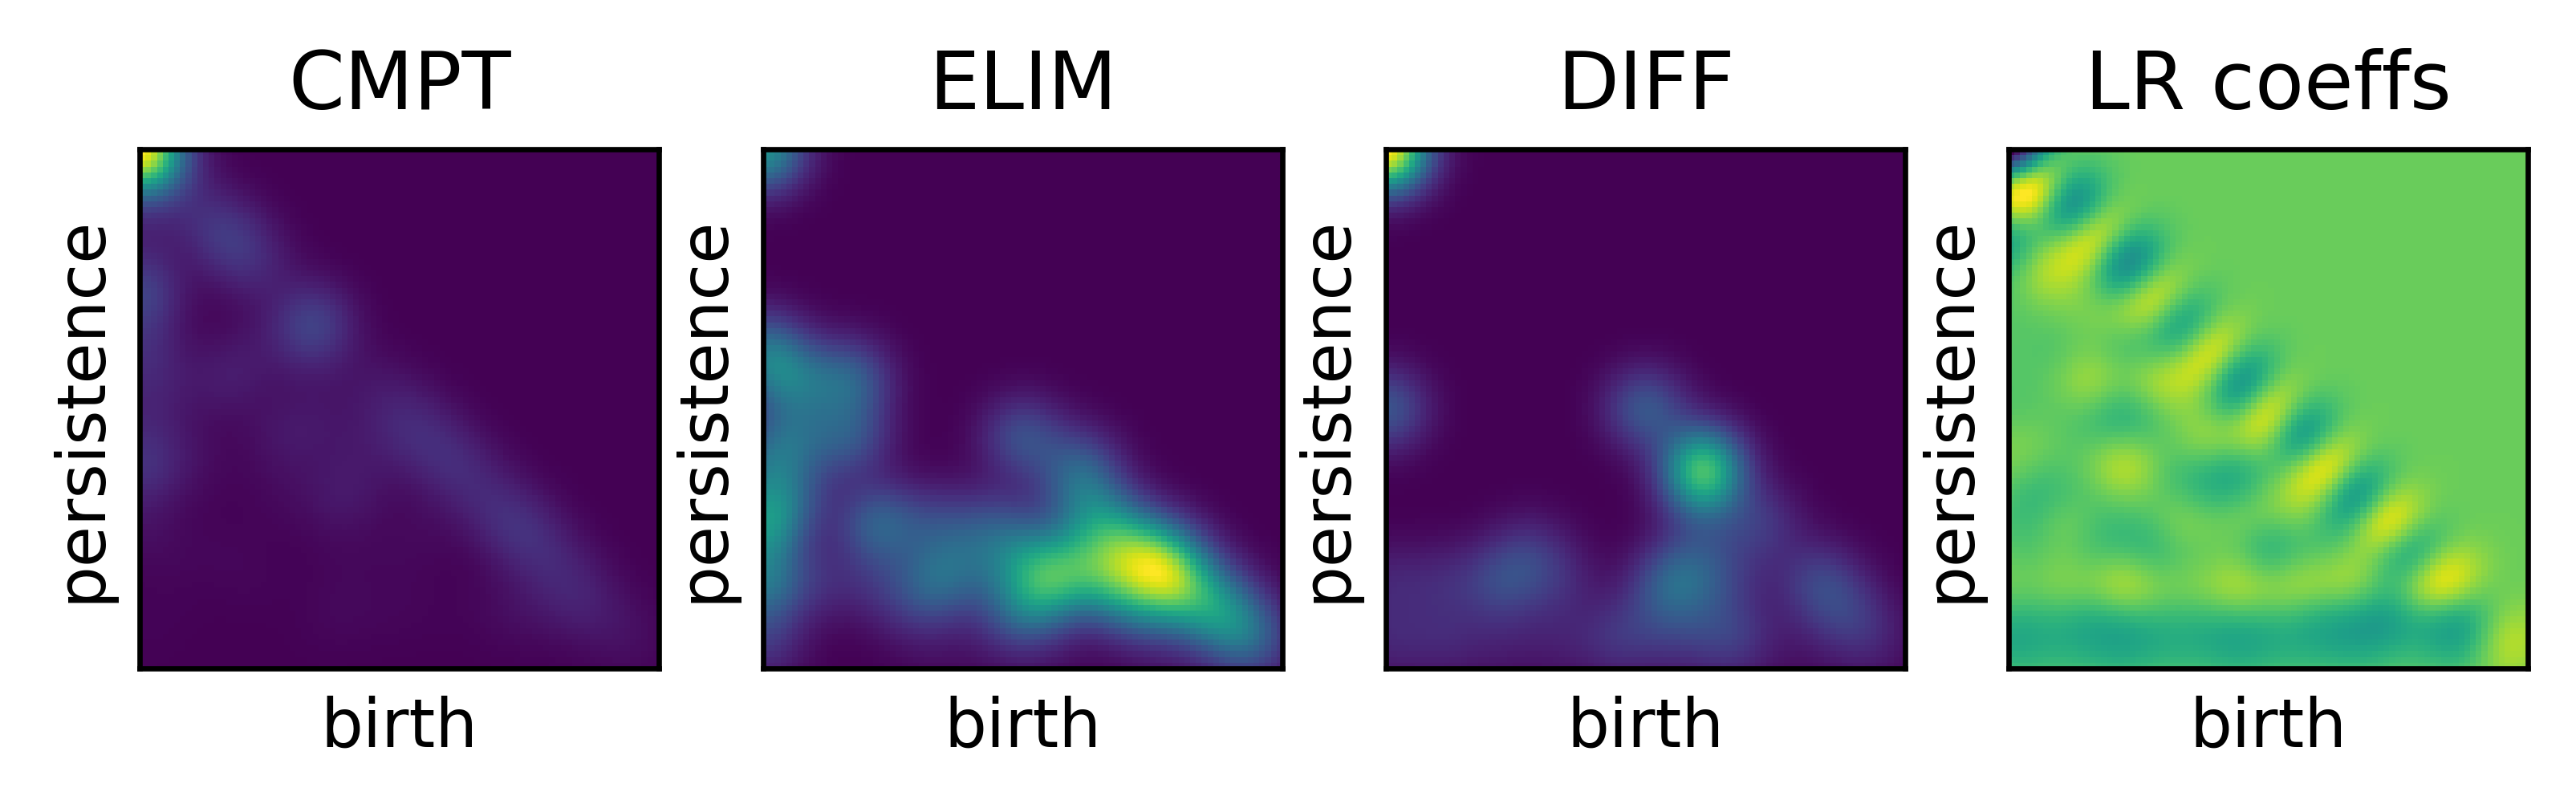

[0.88215488 0.8956229  0.86195286 0.86195286 0.93602694 0.88215488
 0.89225589 0.87542088 0.88552189 0.89225589 0.87542088 0.8989899
 0.8956229  0.87542088 0.86868687 0.87542088 0.87878788 0.8989899
 0.88215488 0.87878788 0.88215488 0.88888889 0.88215488 0.85185185
 0.8989899  0.8989899  0.85858586 0.85521886 0.91245791 0.8956229
 0.88888889 0.88888889 0.91582492 0.85521886 0.83838384 0.87878788
 0.88215488 0.84511785 0.86868687 0.89225589 0.88888889 0.88215488
 0.87878788 0.85521886 0.9023569  0.85185185 0.86195286 0.8956229
 0.88552189 0.8989899 ]


  9%|███▋                                    | 135/1485 [00:15<02:33,  8.78it/s]/Users/jingjieyang/opt/anaconda3/lib/python3.8/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/Users/jingjieyang/opt/anaconda3/lib/python3.8/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
 18%|███████                                 | 264/1485 [00:31<02:22,  8.55it/s]/Users/jingjieyang/opt/anaconda3/lib/python3.8/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
 20%|████████▏                               | 303/1485 [00:35<02:15,  8.74it/s]/Users/jingjieyang/opt/anaconda3/lib/python3.8/si

0.9023569023569024


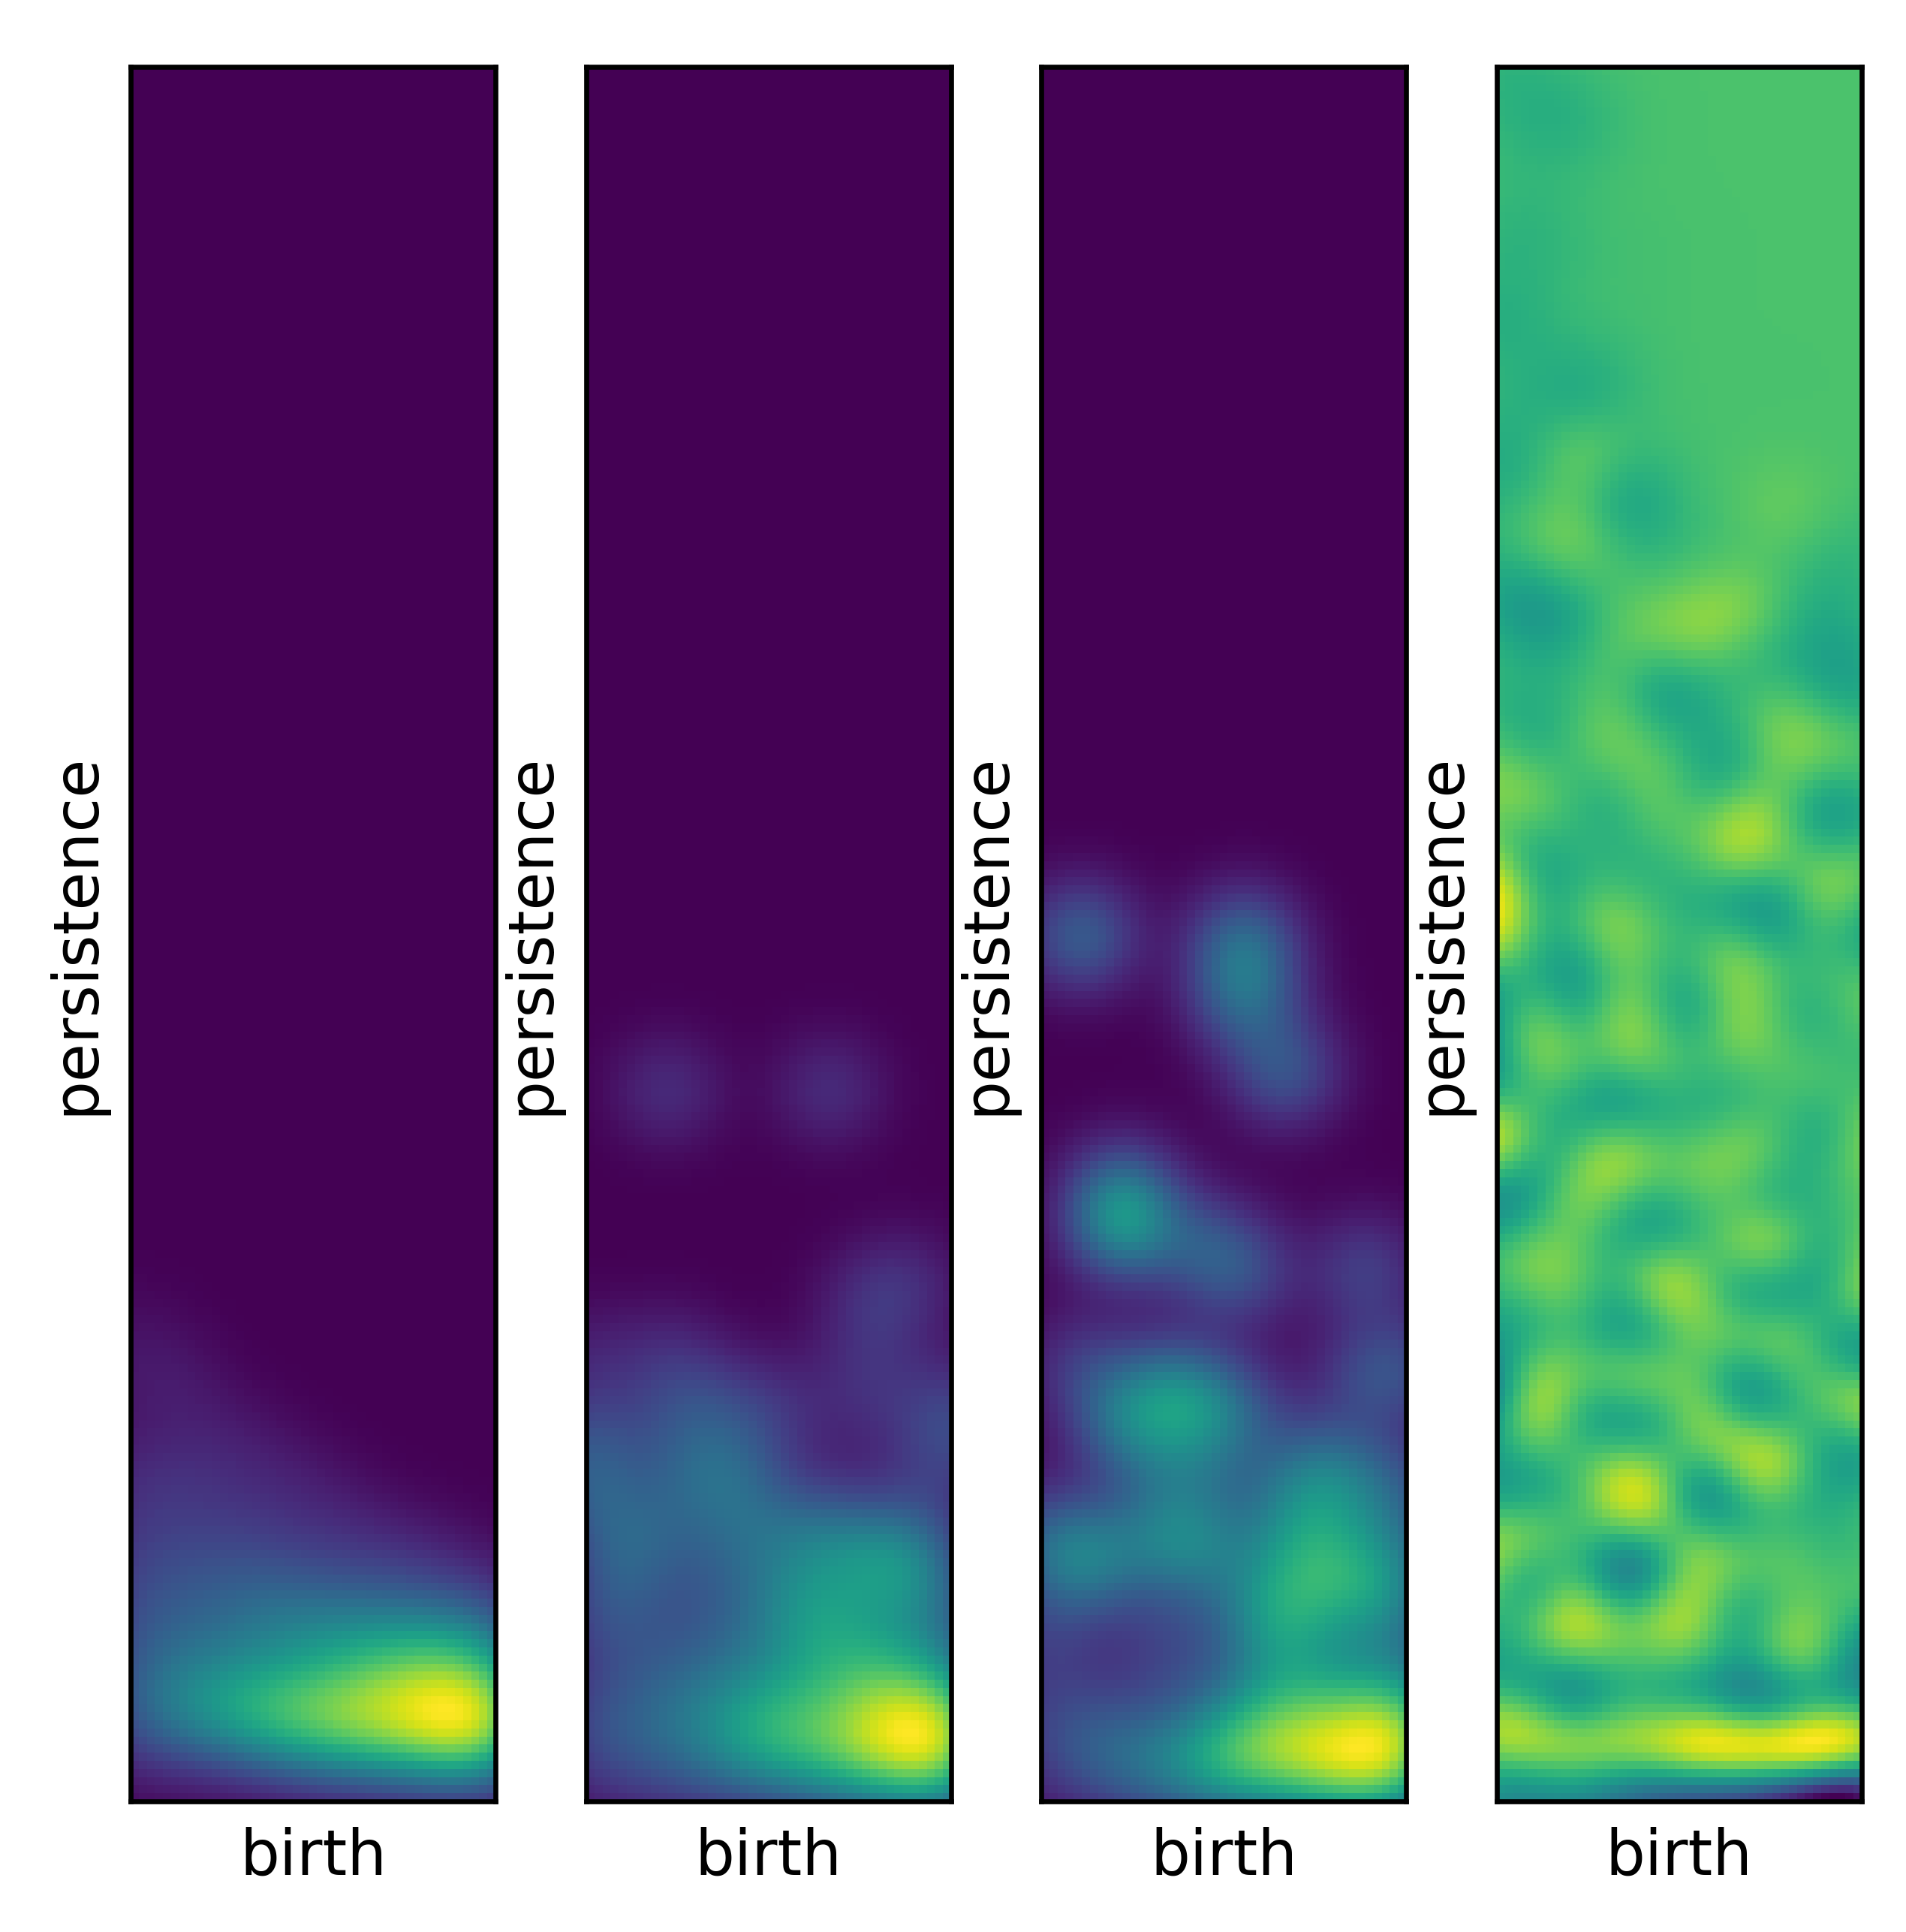

[0.84175084 0.86531987 0.86195286 0.86195286 0.88552189 0.87878788
 0.86195286 0.85858586 0.87542088 0.84848485 0.85521886 0.8956229
 0.87878788 0.87878788 0.83501684 0.87542088 0.85521886 0.85858586
 0.87205387 0.85858586 0.86531987 0.84511785 0.87878788 0.87205387
 0.84511785 0.85858586 0.87205387 0.85858586 0.85185185 0.86195286
 0.86868687 0.85185185 0.86531987 0.85858586 0.85521886 0.87878788
 0.83501684 0.87542088 0.86868687 0.86868687 0.84511785 0.88215488
 0.88552189 0.83164983 0.86195286 0.84848485 0.85521886 0.88215488
 0.86531987 0.86868687]


In [20]:
START = 25
END = 35
STEP = 1




diagrams_h0_zz = []
for i, ID in enumerate(tqdm.tqdm(params.id)):
    dgms = zigzag_dgms(ID, 'Macrophage', MU=2)
    diagrams_h0_zz.append( dgms )
    
pimgr_zz = PersistenceImager()
imgs_zz = pimgr_zz.fit_transform(diagrams_h0_zz)
imgs_array_zz = np.array([
    img.flatten()
    for img in imgs_zz
])

clf = LogisticRegression(max_iter=1000)
clf.fit(imgs_array_zz, labels)
print(clf.score(imgs_array_zz, labels))
inverse_image_zz = np.copy(clf.coef_).reshape(pimgr_zz.resolution)

fig = plt.figure(dpi=600)

pimgr_zz.plot_image(imgs_zz[i0], fig.add_subplot(141)); plt.title("CMPT")
pimgr_zz.plot_image(imgs_zz[i1], fig.add_subplot(142)); plt.title("ELIM")
pimgr_zz.plot_image(imgs_zz[i2], fig.add_subplot(143)); plt.title("DIFF")
pimgr_zz.plot_image(inverse_image_zz, fig.add_subplot(144)); plt.title("LR coeffs")
plt.show()

cv = RepeatedStratifiedKFold()
print( cross_val_score(clf, imgs_array_zz, labels, cv=cv) )



diagrams_h0_rs = []
for ID in tqdm.tqdm(params.id):
    diagrams_h0_rs.append( rips_dgms0(ID, 'Macrophage') )
    
pimgr_rs = PersistenceImager()
imgs_rs = pimgr_rs.fit_transform(diagrams_h0_rs, skew=False)    
imgs_array_rs = np.array([
    img.flatten()
    for img in imgs_rs
])

clf = LogisticRegression(max_iter=1000)
clf.fit(imgs_array_rs, labels)
print(clf.score(imgs_array_rs, labels))
fig = plt.figure(dpi=600, figsize=(5,5))
inverse_image_rs = np.copy(clf.coef_).reshape(pimgr_rs.resolution)
pimgr_rs.plot_image(imgs_rs[i0], fig.add_subplot(141))
pimgr_rs.plot_image(imgs_rs[i1], fig.add_subplot(142))
pimgr_rs.plot_image(imgs_rs[i2], fig.add_subplot(143))
pimgr_rs.plot_image(inverse_image_rs, fig.add_subplot(144))
plt.show()

cv = RepeatedStratifiedKFold()
print( cross_val_score(clf, imgs_array_rs, labels, cv=cv) )





In [21]:
START = 35
END = 36
STEP = 1



diagrams_h0_rst = []
empty_idx = []
for i, ID in enumerate(tqdm.tqdm(params.id)):
    dgms = rips_dgms0(ID, 'Macrophage')
    if dgms.size == 0:
        empty_idx.append(i)
        dgms = np.array([ [0,1], [1,2] ])
    diagrams_h0_rst.append( dgms )

pimgr_rst = PersistenceImager()
pimgr_rst.fit(diagrams_h0_rst, skew=False)    
pimgr_rst.birth_range = (0,1)
imgs_rm = pimgr_rst.transform(diagrams_h0_rst, skew=False)
imgs_array_rst = np.array([
    img.flatten()
    for img in imgs_rm
])
for i in empty_idx:
    imgs_rm[i] = np.zeros(pimgr_rst.resolution)
    imgs_array_rst[i] = np.zeros(pimgr_rst.resolution).flatten()

clf = LogisticRegression(max_iter=1000)
clf.fit(imgs_array_rst, labels)
inverse_image_rm = np.copy(clf.coef_).reshape(pimgr_rst.resolution)

cv = RepeatedStratifiedKFold()
print( cross_val_score(clf, imgs_array_rst, labels, cv=cv) )



diagrams_h0_rst = []
empty_idx = []
for i, ID in enumerate(tqdm.tqdm(params.id)):
    dgms = rips_dgms1(ID, 'Tumour')
    if dgms.size == 0:
        empty_idx.append(i)
        dgms = np.array([ [0,1], [1,2] ])
    diagrams_h0_rst.append( dgms )

pimgr_rst = PersistenceImager()
pimgr_rst.fit(diagrams_h0_rst, skew=False)    
pimgr_rst.birth_range = (0,1)
imgs_rt = pimgr_rst.transform(diagrams_h0_rst, skew=False)
imgs_array_rst = np.array([
    img.flatten()
    for img in imgs_rt
])
for i in empty_idx:
    imgs_rt[i] = np.zeros(pimgr_rst.resolution)
    imgs_array_rst[i] = np.zeros(pimgr_rst.resolution).flatten()

clf = LogisticRegression(max_iter=1000)
clf.fit(imgs_array_rst, labels)
inverse_image_rt = np.copy(clf.coef_).reshape(pimgr_rst.resolution)

cv = RepeatedStratifiedKFold()
print( cross_val_score(clf, imgs_array_rst, labels, cv=cv) )


100%|███████████████████████████████████████| 1485/1485 [02:17<00:00, 10.84it/s]


[0.82828283 0.82491582 0.83838384 0.88215488 0.85858586 0.84511785
 0.84511785 0.82154882 0.86195286 0.85185185 0.83838384 0.85185185
 0.83838384 0.83164983 0.86195286 0.86531987 0.82491582 0.83164983
 0.82828283 0.86868687 0.83501684 0.86195286 0.85521886 0.85185185
 0.83501684 0.82828283 0.85521886 0.83501684 0.85521886 0.83501684
 0.84175084 0.85185185 0.85185185 0.85185185 0.83501684 0.86195286
 0.85521886 0.82828283 0.82154882 0.84175084 0.85858586 0.84511785
 0.82828283 0.82828283 0.87205387 0.83501684 0.86531987 0.80808081
 0.84175084 0.86195286]


 33%|█████████████▏                          | 490/1485 [01:12<01:45,  9.46it/s]/Users/jingjieyang/opt/anaconda3/lib/python3.8/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
 33%|█████████████▎                          | 494/1485 [01:12<01:36, 10.31it/s]/Users/jingjieyang/opt/anaconda3/lib/python3.8/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/Users/jingjieyang/opt/anaconda3/lib/python3.8/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
 33%|█████████████▎                          | 496/1485 [01:12<01:34, 10.51it/s]/Users/jingjieyang/opt/anaconda3/lib/python3.8/si

[0.90909091 0.86868687 0.86868687 0.82491582 0.87542088 0.86868687
 0.86195286 0.87878788 0.86531987 0.87205387 0.87542088 0.88552189
 0.86195286 0.87205387 0.86195286 0.88215488 0.86531987 0.86531987
 0.8956229  0.83838384 0.87542088 0.86195286 0.86868687 0.86868687
 0.86531987 0.84511785 0.87205387 0.86195286 0.86531987 0.90572391
 0.84848485 0.85185185 0.87878788 0.88552189 0.87878788 0.84175084
 0.88888889 0.88215488 0.85858586 0.88215488 0.83501684 0.8989899
 0.86195286 0.88215488 0.86868687 0.85521886 0.88215488 0.88215488
 0.86531987 0.85858586]


In [50]:
type(gs[0,0])

matplotlib.gridspec.SubplotSpec

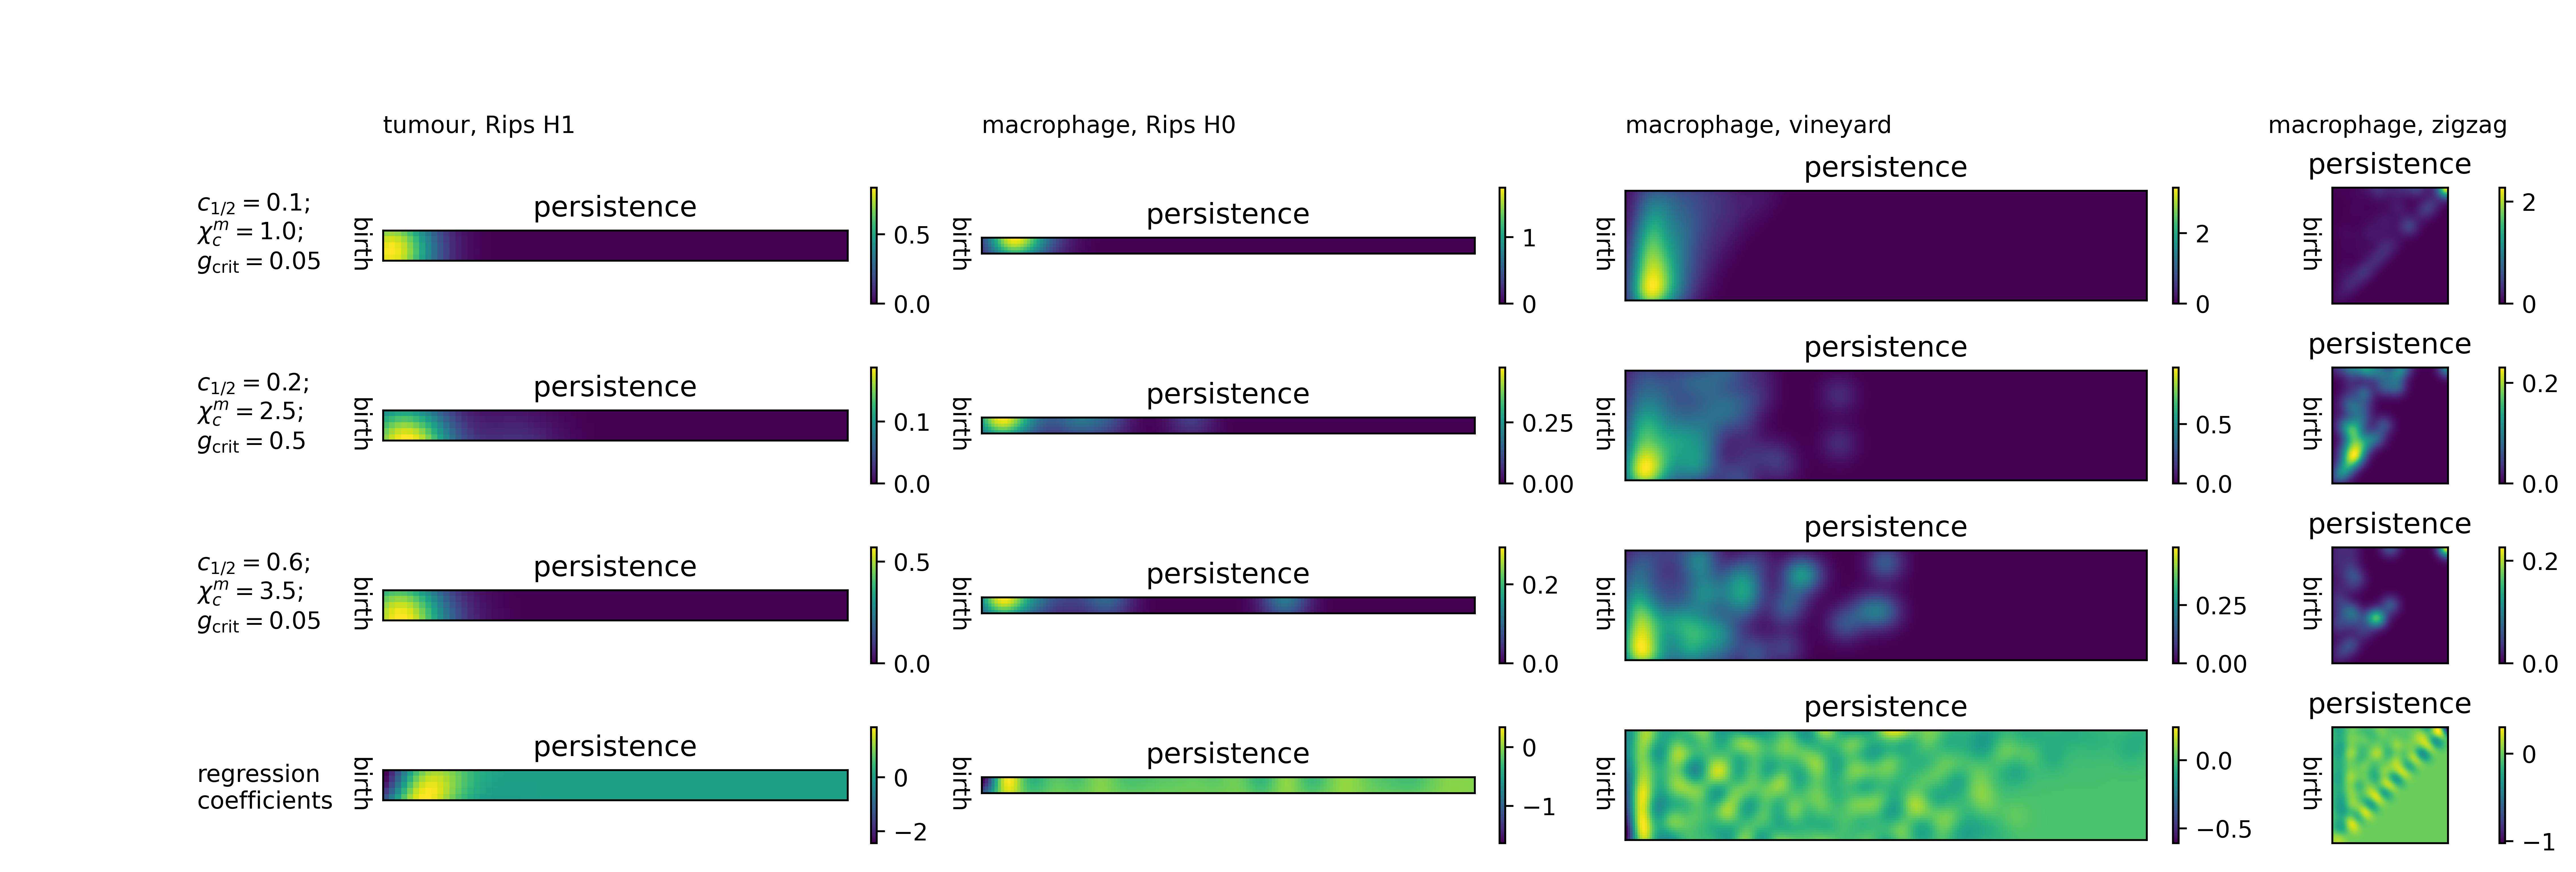

In [148]:
fig = plt.figure(figsize=(15,5), dpi=600, constrained_layout=True)

gs = fig.add_gridspec(5,8)

imgs = [
    [imgs_rt[i0], imgs_rt[i1], imgs_rt[i2], inverse_image_rt],
    [imgs_rm[i0], imgs_rm[i1], imgs_rm[i2], inverse_image_rm],
    [imgs_rs[i0], imgs_rs[i1], imgs_rs[i2], inverse_image_rs],
    [imgs_zz[i0], imgs_zz[i1], imgs_zz[i2], inverse_image_zz],
]
for i, row in enumerate(imgs):
    for j, img in enumerate(row):
        if i <= 2:
            ax = fig.add_subplot(gs[j+1, 2*i+1:2*i+3])
        else:
            ax = fig.add_subplot(gs[j+1, 2*i+1:2*i+2])
        im = ax.imshow(img)
        cb = fig.colorbar(im, ax=ax)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel("birth", rotation=-90, labelpad=15)
        ax.set_title("persistence")

for i, label in enumerate([r"$c_{1/2} = 0.1;$" + '\n' + r"$\chi_c^m = 1.0;$" + '\n' + r"$g_\mathrm{crit} = 0.05$", r"$c_{1/2} = 0.2;$" + '\n' + r"$\chi_c^m = 2.5;$" + '\n' + r"$g_\mathrm{crit} = 0.5$", r"$c_{1/2} = 0.6;$" + '\n' + r"$\chi_c^m = 3.5;$" + '\n' + r"$g_\mathrm{crit} = 0.05$", "regression" + '\n' + "coefficients"]):
    ax = fig.add_subplot(gs[i+1, 0])
    ax.axis('off')
    ax.text(1, 0.3, label)
for i, label in enumerate(["tumour, Rips H1", "macrophage, Rips H0", "macrophage, vineyard", "macrophage, zigzag"]):
    ax = fig.add_subplot(gs[0, 2*i+1])
    ax.axis('off')
    ax.text(0, 0, label)
plt.show(fig)

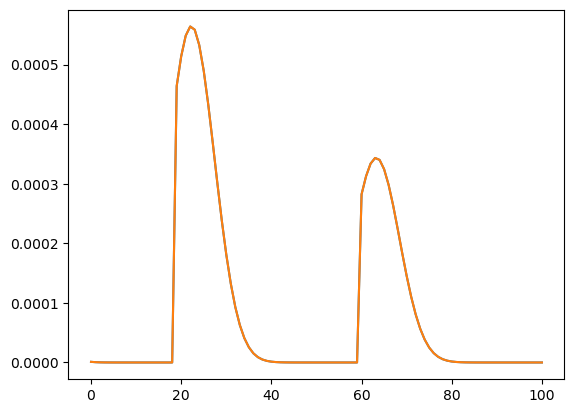

In [23]:
plt.plot(combined_array[i0][-101:])
plt.show()

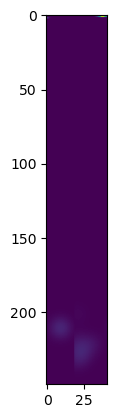

In [46]:
plt.imshow(combined_array[i2][:-101].reshape(pimgr.resolution))
plt.show()

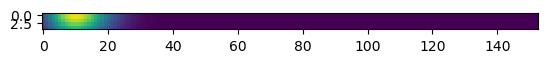

In [36]:
plt.imshow(imgs_rm[i0])
plt.show()


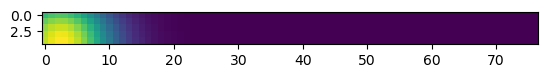

In [39]:
plt.imshow(imgs_rt[i2])
plt.show()
